In [1]:
import time
from datetime import datetime

import torch
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
GPU = 0
device = torch.device("cuda:{}".format(GPU)) if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Param list
EPOCH = 300
TIMESTEP = 12
TRAINDAYS = 30

OPTIMIZER = 'Adam'
LEARN = 0.0001
PATIENCE = 20
beijing = None
changchun = None
shenzhen = None
shanghai = None
Loss = nn.L1Loss()
scaler_dict = dict()
model_dict = dict()
scaler_x = StandardScaler()

In [3]:
def csv_to_tensor(file):
    Data = pd.read_csv(file)
    scaler = StandardScaler()
    scaler_dict[file.split('/')[2][0:-9]] = scaler
    f = Data['confirmedNum'].to_numpy()[::-1].reshape(42, 1).astype(float)
    f = scaler.fit_transform(f)
    x_data = np.arange(0, 42, 1)
    x_data = x_data.reshape(-1, 1).astype(int)
    x_data = scaler_x.fit_transform(x_data)
    data = np.append(x_data, values=f, axis=1)
    d = torch.from_numpy(data.copy())
    return d


In [4]:
def read_csv_to_list():
    global beijing
    global shenzhen
    global changchun
    global shanghai
    beijing = csv_to_tensor('./input/beijing_data.csv')
    shenzhen = csv_to_tensor('./input/shenzhen_data.csv')
    changchun = csv_to_tensor('./input/changchun_data.csv')
    shanghai = csv_to_tensor('./input/shanghai_data.csv')


read_csv_to_list()

In [5]:
shenzhen

tensor([[-1.6913, -1.3168],
        [-1.6088, -1.2994],
        [-1.5263, -1.2835],
        [-1.4438, -1.2739],
        [-1.3613, -1.2517],
        [-1.2788, -1.2184],
        [-1.1963, -1.1961],
        [-1.1138, -1.1739],
        [-1.0313, -1.1358],
        [-0.9488, -1.0913],
        [-0.8663, -1.0532],
        [-0.7838, -0.9977],
        [-0.7013, -0.9468],
        [-0.6188, -0.8500],
        [-0.5363, -0.7706],
        [-0.4538, -0.6420],
        [-0.3713, -0.5467],
        [-0.2888, -0.3593],
        [-0.2063, -0.2244],
        [-0.1238, -0.1021],
        [-0.0413, -0.0180],
        [ 0.0413,  0.0614],
        [ 0.1238,  0.1107],
        [ 0.2063,  0.1678],
        [ 0.2888,  0.2393],
        [ 0.3713,  0.3155],
        [ 0.4538,  0.4378],
        [ 0.5363,  0.5981],
        [ 0.6188,  0.6839],
        [ 0.7013,  0.7934],
        [ 0.7838,  0.9252],
        [ 0.8663,  1.0475],
        [ 0.9488,  1.1364],
        [ 1.0313,  1.2460],
        [ 1.1138,  1.3031],
        [ 1.1963,  1

In [6]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.__padding = (kernel_size - 1) * dilation

    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class context_embedding(torch.nn.Module):
    def __init__(self, in_channels=1, embedding_size=256, k=5):
        super(context_embedding, self).__init__()
        self.causal_convolution = CausalConv1d(in_channels, embedding_size, kernel_size=k)

    def forward(self, x):
        x = self.causal_convolution(x)
        return torch.tanh(x)


class Transformer(nn.Module):
    def __init__(self, device=device, dmodel=256):
        super(Transformer, self).__init__()
        self.input_embedding = context_embedding(2, dmodel,5)
        self.positional_embedding = torch.nn.Embedding(TIMESTEP, dmodel)
        self.device = device
        self.dmodel = dmodel
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=dmodel, nhead=4)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=6)
        self.fc1 = torch.nn.Linear(dmodel, int(dmodel / 2))
        self.fc12 = torch.nn.Linear(int(dmodel / 2), 1)
        self.fc2 = torch.nn.Linear(TIMESTEP, 1)

    def forward(self, x, y, attention_mask):
        z = torch.cat((y.unsqueeze(1), x.unsqueeze(1)), 1)
        z_embedding = self.input_embedding(z).permute(2, 0, 1)
        positional_embeddings = self.positional_embedding(torch.arange(0, TIMESTEP).to(self.device)).expand(1, TIMESTEP,
                                                                                                            self.dmodel).permute(
            1, 0, 2)

        input_embedding = z_embedding + positional_embeddings
        transformer_embedding = self.transformer_decoder(input_embedding, attention_mask)

        output = self.fc1(transformer_embedding.permute(1, 0, 2))
        output = self.fc12(output).permute(2, 0, 1)
        output = self.fc2(output)
        return output

In [7]:
def evaluate_epoch(model, name,test):
    model.eval()
    l_sum, n = 0.0, 0
    with torch.no_grad():
        for i in range(0, TIMESTEP):
            x = test[i + TRAINDAYS - TIMESTEP: i + TRAINDAYS, 0].reshape(1, -1).float()
            y = test[i + TRAINDAYS - TIMESTEP: i + TRAINDAYS, 1].reshape(1, -1).float()
            attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
            y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
            # y_pred = model(x.cuda())[0][0]
            loss = Loss(y_pred.float(), test[i + TRAINDAYS][1].cuda().float())
            l_sum += loss.item() * y.shape[0]
            n += y.shape[0]
        return l_sum / n


In [8]:
def train(model, name, data):
    print('Model Training Started ...', time.ctime())
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARN)
    min_val_loss = np.inf
    for epoch in range(EPOCH):
        starttime = datetime.now()
        model.train()
        loss_sum, n = 0.0, 0
        for i in range(0, TRAINDAYS - TIMESTEP):
            optimizer.zero_grad()
            x = data[i:i + TIMESTEP, 0].reshape(1, -1).float()
            y = data[i:i + TIMESTEP, 1].reshape(1, -1).float()
            attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
            y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
            y = data[i + TIMESTEP][1]
            loss = Loss(y_pred.float(), y.cuda().float())
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            n += 1
        train_loss = loss_sum / n
        val_loss = evaluate_epoch(model,name, data)
        if val_loss < min_val_loss:
            wait = 0
            min_val_loss = val_loss
            open('./model/' + name + '.pt', 'a')
            torch.save(model.state_dict(), './model/' + name + '.pt')
        else:
            wait += 1
            if wait == PATIENCE:
                print('Early stopping at epoch: %d' % epoch)
                break
        endtime = datetime.now()
        epoch_time = (endtime - starttime).seconds
        print("epoch", epoch, "time used:", epoch_time, " seconds ", "train loss:", train_loss, "validation loss:",
              val_loss)
    print('Model Training Ended ...', time.ctime())

In [9]:
import Metrics


def test_model(model, name, data):
    loss = nn.L1Loss()
    print('Model Testing Started ...', time.ctime())
    model.load_state_dict(torch.load('./model/' + name + '.pt'))
    YS = data[30:42, 1]
    YS_pred = []
    scaler = scaler_dict[name]
    with torch.no_grad():

        for i in range(0, TIMESTEP):
            x = data[i + TRAINDAYS - TIMESTEP: i + TRAINDAYS, 0].reshape(1, -1).float()
            y = data[i + TRAINDAYS - TIMESTEP: i + TRAINDAYS, 1].reshape(1, -1).float()
            attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
            y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
            YS_pred.append(y_pred.cpu())
    YS_pred = np.array(YS_pred)
    YS = scaler.inverse_transform(YS.reshape(-1,1))
    YS_pred = scaler.inverse_transform(YS_pred.reshape(-1,1))
    Mae = 0
    for i in range(TIMESTEP):
        MSE, RMSE, MAE, MAPE = Metrics.evaluate(YS[i], YS_pred[i])
        Mae += MAE
        print("%d step, %s, %s, MSE, RMSE, MAE, MAPE, %.10f, %.10f, %.10f, %.10f" % (
            i + 1, name, 'Transformer', MSE, RMSE, MAE, MAPE))
    print("Average MAE Loss is %.10f" % (Mae/TIMESTEP))
    print('Model Testing Ended ...', time.ctime())


In [60]:
# train every city
model = Transformer().cuda(device=device)
model_dict['shenzhen'] = model
train(model,'shenzhen',shenzhen)

Model Training Started ... Wed May 25 00:17:07 2022
epoch 0 time used: 0  seconds  train loss: 0.5375872548255656 validation loss: 0.8929662356774012
epoch 1 time used: 0  seconds  train loss: 0.6862805634737015 validation loss: 0.9380410214265188
epoch 2 time used: 0  seconds  train loss: 0.6756007153954771 validation loss: 1.1647707720597584
epoch 3 time used: 0  seconds  train loss: 0.44027268555429244 validation loss: 0.5915596832831701
epoch 4 time used: 0  seconds  train loss: 0.7609661858942773 validation loss: 1.0447187920411427
epoch 5 time used: 0  seconds  train loss: 0.3616543552941746 validation loss: 0.38729166487852734
epoch 6 time used: 0  seconds  train loss: 0.5656071681943204 validation loss: 0.39563105007012683
epoch 7 time used: 0  seconds  train loss: 0.35695399426751667 validation loss: 0.4507143547137578
epoch 8 time used: 0  seconds  train loss: 0.402570909096135 validation loss: 0.04582233726978302
epoch 9 time used: 0  seconds  train loss: 0.5330815530485578 

In [51]:
model = Transformer().cuda(device=device)
model_dict['shanghai'] = model
train(model,'shanghai',shanghai)

Model Training Started ... Wed May 25 00:14:03 2022
epoch 0 time used: 0  seconds  train loss: 0.1507881654219495 validation loss: 0.3567046821117401
epoch 1 time used: 0  seconds  train loss: 0.9340717155072424 validation loss: 1.1515306482712429
epoch 2 time used: 0  seconds  train loss: 0.681251608663135 validation loss: 1.4428867399692535
epoch 3 time used: 0  seconds  train loss: 0.5797837417986658 validation loss: 1.3414975106716156
epoch 4 time used: 0  seconds  train loss: 0.5616907949248949 validation loss: 1.2835944096247356
epoch 5 time used: 0  seconds  train loss: 0.5775509331789281 validation loss: 1.2456178019444148
epoch 6 time used: 0  seconds  train loss: 0.5676545126156675 validation loss: 1.1677429974079132
epoch 7 time used: 0  seconds  train loss: 0.5217886434661018 validation loss: 0.9096392368276914
epoch 8 time used: 0  seconds  train loss: 0.5129686511225171 validation loss: 1.0472645262877147
epoch 9 time used: 0  seconds  train loss: 0.3379662235577901 valid

In [32]:
model = Transformer().cuda(device=device)
model_dict['beijing'] = model
train(model,'beijing',beijing)

Model Training Started ... Wed May 25 00:06:02 2022
epoch 0 time used: 0  seconds  train loss: 0.4005847740918398 validation loss: 0.8380992462237676
epoch 1 time used: 0  seconds  train loss: 0.8942827946609921 validation loss: 1.0745936731497447
epoch 2 time used: 0  seconds  train loss: 0.8725195088320308 validation loss: 1.360716422398885
epoch 3 time used: 0  seconds  train loss: 0.5940788206126955 validation loss: 0.9001207277178764
epoch 4 time used: 0  seconds  train loss: 0.6994663659069273 validation loss: 0.5227942417065302
epoch 5 time used: 0  seconds  train loss: 0.32520221960213447 validation loss: 0.21491231520970663
epoch 6 time used: 0  seconds  train loss: 0.12311247156725989 validation loss: 0.5954078882932663
epoch 7 time used: 0  seconds  train loss: 1.0252655127810106 validation loss: 1.2010457863410313
epoch 8 time used: 0  seconds  train loss: 0.5978943291637633 validation loss: 1.0634335279464722
epoch 9 time used: 0  seconds  train loss: 0.3790261712339189 va

In [48]:
model = Transformer().cuda(device=device)
model_dict['changchun'] = model
train(model,'changchun',changchun)

Model Training Started ... Wed May 25 00:12:07 2022
epoch 0 time used: 0  seconds  train loss: 0.2753578759729862 validation loss: 0.4509222408135732
epoch 1 time used: 0  seconds  train loss: 0.4214513657821549 validation loss: 0.13889404137929282
epoch 2 time used: 0  seconds  train loss: 0.4013308162490527 validation loss: 0.27477051317691803
epoch 3 time used: 0  seconds  train loss: 0.3869887159930335 validation loss: 0.42583416899045307
epoch 4 time used: 0  seconds  train loss: 0.29895170943604576 validation loss: 0.21189872920513153
epoch 5 time used: 0  seconds  train loss: 0.29597243252727723 validation loss: 0.22213909526666006
epoch 6 time used: 0  seconds  train loss: 0.2788792434665892 validation loss: 0.3561876118183136
epoch 7 time used: 0  seconds  train loss: 0.3784111477434635 validation loss: 0.48056093603372574
epoch 8 time used: 0  seconds  train loss: 0.2476498952342404 validation loss: 0.13859882454077402
epoch 9 time used: 0  seconds  train loss: 0.207376975152

In [61]:
test_model(model_dict['shenzhen'],'shenzhen',shenzhen)

Model Testing Started ... Wed May 25 00:17:31 2022
1 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 4121.1008379459, 64.1958007812, 64.1958007812, 4.5464448145
2 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 3330.9327367693, 57.7142333984, 57.7142333984, 3.8760398521
3 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 2054.1298914552, 45.3225097656, 45.3225097656, 2.9334957777
4 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 27.6048135906, 5.2540283203, 5.2540283203, 0.3255283965
5 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 110.7478752732, 10.5236816406, 10.5236816406, 0.6377988873
6 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 387.4342518449, 19.6833496094, 19.6833496094, 1.1758273363
7 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 595.0633767992, 24.3939208984, 24.3939208984, 1.4434272721
8 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 618.6320262551, 24.8723144531, 24.8723144531, 1.4639384610
9 step, shenzhen, Transformer, MSE, RMSE, MAE, MAPE, 

In [52]:
test_model(model_dict['shanghai'],'shanghai',shanghai)

Model Testing Started ... Wed May 25 00:15:13 2022
1 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 26234003.6636352539, 5121.9140625000, 5121.9140625000, 11.5812283781
2 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 13028856.8424224854, 3609.5507812500, 3609.5507812500, 7.9299415204
3 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 5128561.7754516602, 2264.6328125000, 2264.6328125000, 4.4398471043
4 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 14430768.6633453369, 3798.7851562500, 3798.7851562500, 7.2694283182
5 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 20403783.0498657227, 4517.0546875000, 4517.0546875000, 8.5153540088
6 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 27342481.8515777588, 5229.0039062500, 5229.0039062500, 9.7238566364
7 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 32986625.6118774414, 5743.3984375000, 5743.3984375000, 10.6262806666
8 step, shanghai, Transformer, MSE, RMSE, MAE, MAPE, 41110888.7058258057, 6411.7773437500, 6411.77734

In [38]:
test_model(model_dict['beijing'],'beijing',beijing)

Model Testing Started ... Wed May 25 00:07:29 2022
1 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 705.9620458037, 26.5699462891, 26.5699462891, 3.8340470836
2 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 1187.1187613010, 34.4545898438, 34.4545898438, 4.5635218336
3 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 2665.8590877205, 51.6319580078, 51.6319580078, 6.6194817959
4 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 1771.8067139424, 42.0928344727, 42.0928344727, 5.1647649660
5 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 220.6033557989, 14.8527221680, 14.8527221680, 1.7310864998
6 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 45.7786370665, 6.7659912109, 6.7659912109, 0.7602237316
7 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 1078.2068081051, 32.8360595703, 32.8360595703, 3.5575362481
8 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 4482.4103790671, 66.9508056641, 66.9508056641, 6.9595432083
9 step, beijing, Transformer, MSE, RMSE, MAE, MAPE, 11356.5

In [49]:
test_model(model_dict['changchun'],'changchun',changchun)

Model Testing Started ... Wed May 25 00:13:30 2022
1 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 16118.0877838135, 126.9570312500, 126.9570312500, 0.5532378911
2 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 152087.8127441406, 389.9843750000, 389.9843750000, 1.6934490208
3 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 224370.5960426331, 473.6777343750, 473.6777343750, 2.0415383776
4 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 135747.6306190491, 368.4394531250, 368.4394531250, 1.5686952490
5 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 119178.6823883057, 345.2226562500, 345.2226562500, 1.4612599206
6 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 70670.8225250244, 265.8398437500, 265.8398437500, 1.1178195431
7 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 35858.4522857666, 189.3632812500, 189.3632812500, 0.7920829935
8 step, changchun, Transformer, MSE, RMSE, MAE, MAPE, 4744.5727882385, 68.8808593750, 68.8808593750, 0.2863949914
9 step, chan

In [40]:
def predict_day(model, name,days,min):
    model.eval()
    with torch.no_grad():
        x = days[:,0].reshape(1, -1).float()
        y = days[:,1].reshape(1, -1).float()
        attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
        y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
        # Does not output values that defy common sense.
        if y_pred < min:
            y_pred = y[0,-1]
        return scaler_dict[name].inverse_transform(y_pred.cpu().reshape(-1,1))[0][0]

In [41]:
import math
import matplotlib.pyplot as plt

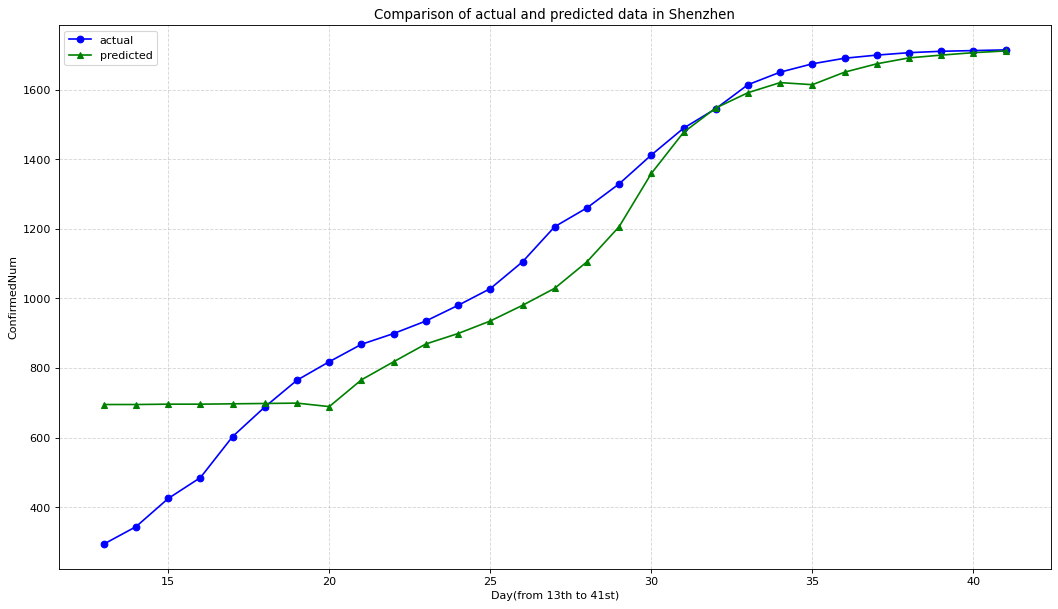

In [62]:
predict_shenzhen = list()
for i in range(0, 29):
    predict_shenzhen.append(math.ceil((predict_day(model_dict['shenzhen'],'shenzhen',shenzhen[i:i+TIMESTEP],shenzhen[i+TIMESTEP][1]))))
np_predict_shenzhen = np.array(predict_shenzhen).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/shenzhen_data.csv" ,header=0)
true_shenzhen = list()
for i in range(0, 29):
    true_shenzhen.append(df.iloc[28 - i, 1])
np_true_shenzhen = np.array(true_shenzhen).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of actual and predicted data in Shenzhen')
plt.plot(x, np_true_shenzhen, color='b', marker='o', label='actual')
plt.plot(x, np_predict_shenzhen, color='g', marker='^', label='predicted')
plt.legend()
plt.show()

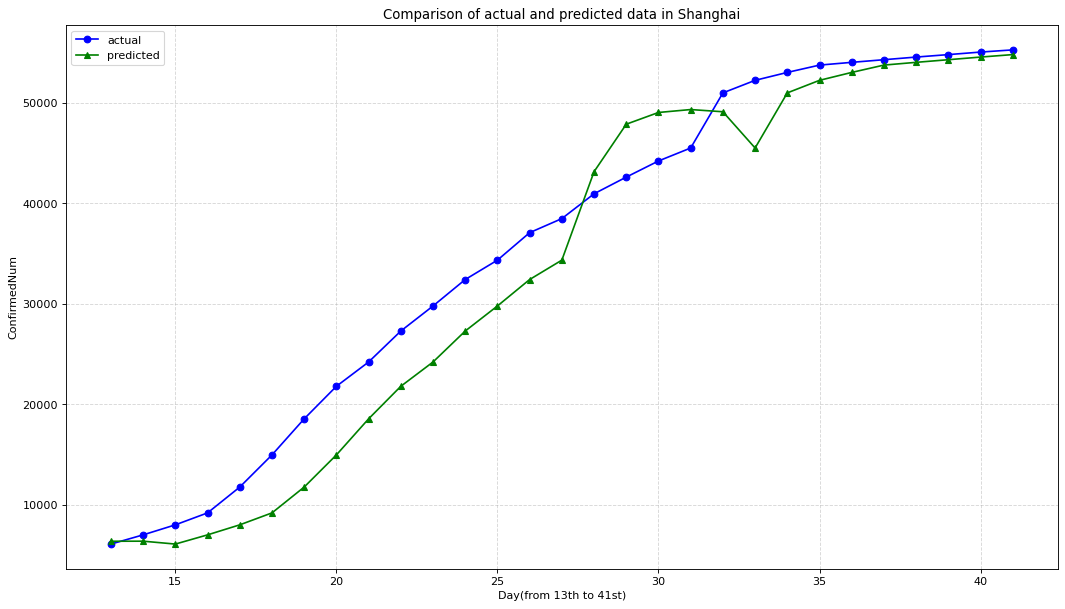

In [53]:
predict_shanghai = list()
for i in range(0, 29):
    predict_shanghai.append(math.ceil((predict_day(model_dict['shanghai'],'shanghai',shanghai[i:i+TIMESTEP],shanghai[i+TIMESTEP][1]))))
np_predict_shanghai = np.array(predict_shanghai).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/shanghai_data.csv" ,header=0)
true_shanghai = list()
for i in range(0, 29):
    true_shanghai.append(df.iloc[28 - i, 1])
np_true_shanghai = np.array(true_shanghai).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of actual and predicted data in Shanghai')
plt.plot(x, np_true_shanghai, color='b', marker='o', label='actual')
plt.plot(x, np_predict_shanghai, color='g', marker='^', label='predicted')
plt.legend()
plt.show()

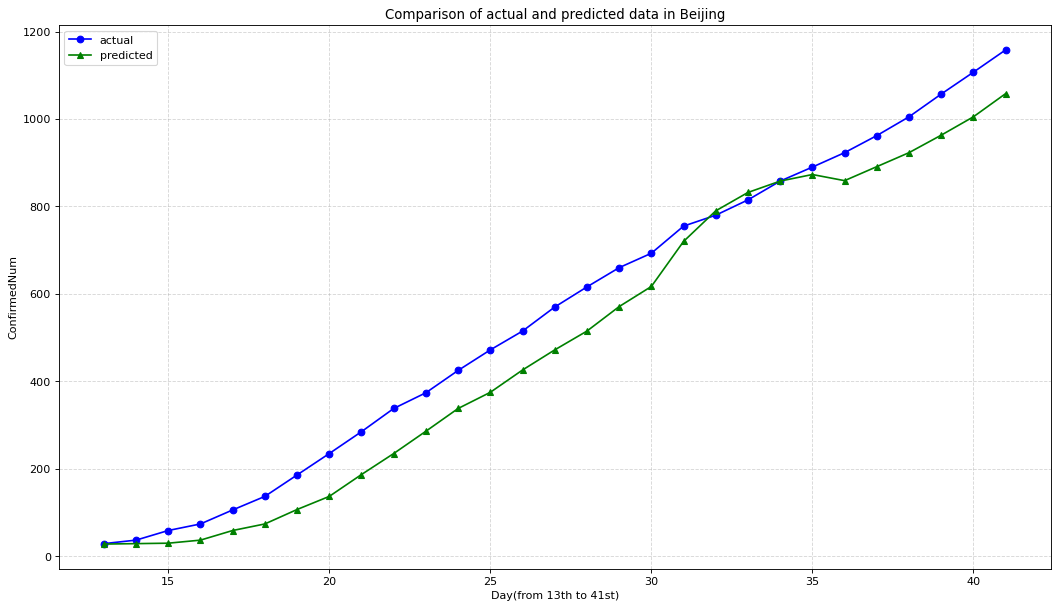

In [44]:
predict_beijing = list()
for i in range(0, 29):
    predict_beijing.append(math.ceil((predict_day(model_dict['beijing'],'beijing',beijing[i:i+TIMESTEP],beijing[i+TIMESTEP][1]))))
np_predict_beijing = np.array(predict_beijing).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/beijing_data.csv" ,header=0)
true_beijing = list()
for i in range(0, 29):
    true_beijing.append(df.iloc[28 - i, 1])
np_true_beijing = np.array(true_beijing).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of actual and predicted data in Beijing')
plt.plot(x, np_true_beijing, color='b', marker='o', label='actual')
plt.plot(x, np_predict_beijing, color='g', marker='^', label='predicted')
plt.legend()
plt.show()

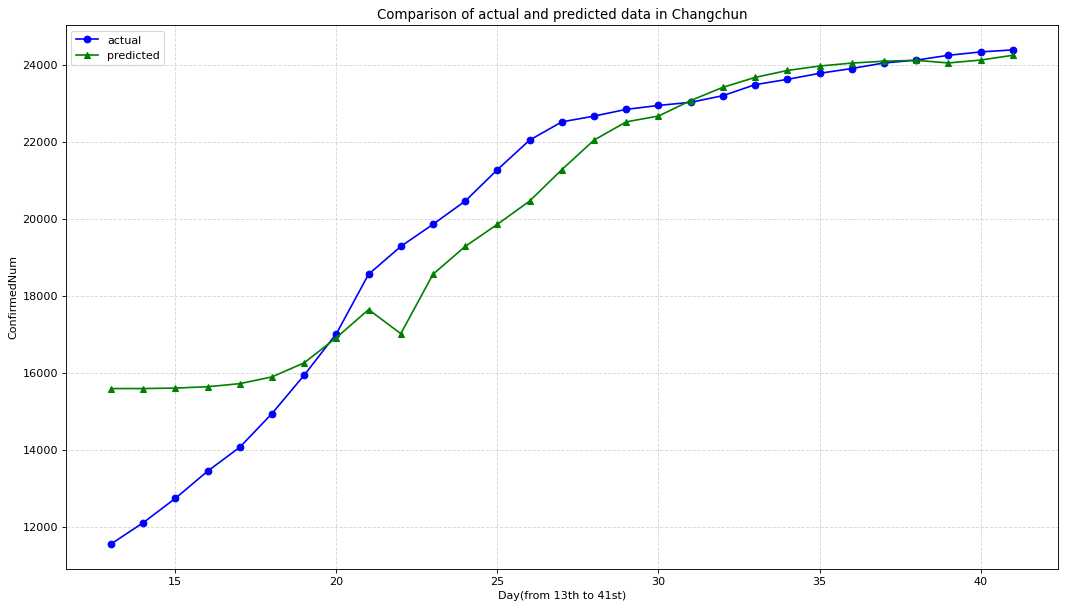

In [65]:
predict_changchun = list()
for i in range(0, 29):
    predict_changchun.append(math.ceil((predict_day(model_dict['changchun'],'changchun',changchun[i:i+TIMESTEP],changchun[i+TIMESTEP][1]))))
np_predict_changchun = np.array(predict_changchun).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/changchun_data.csv" ,header=0)
true_changchun = list()
for i in range(0, 29):
    true_changchun.append(df.iloc[28 - i, 1])
np_true_changchun = np.array(true_changchun).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of actual and predicted data in Changchun')
plt.plot(x, np_true_changchun, color='b', marker='o', label='actual')
plt.plot(x, np_predict_changchun, color='g', marker='^', label='predicted')
plt.legend()
plt.show()

In [24]:
def predict_new(model, name,days,min):
    model.eval()
    with torch.no_grad():
        x = days[:,0].reshape(1, -1).float()
        y = days[:,1].reshape(1, -1).float()
        attention_mask = torch.from_numpy(np.zeros((TIMESTEP, TIMESTEP)))
        y_pred = model(x.cuda(), y.cuda(), attention_mask.cuda())[0][0][0]
        # Does not output values that defy common sense.
        if y_pred < min:
            y_pred = y[0,-1]+0.01
        return y_pred.cpu().reshape(-1, 1)[0][0], scaler_dict[name].inverse_transform(y_pred.cpu().reshape(-1,1))[0][0]

[4048, 4054, 4060, 4067, 4073, 4079, 4086, 4092, 4098, 4104, 4111, 4117, 4123, 4130, 4136, 4142, 4149, 4155, 4161, 4167, 4174, 4180, 4186, 4193, 4199, 4205, 4212, 4218, 4224]


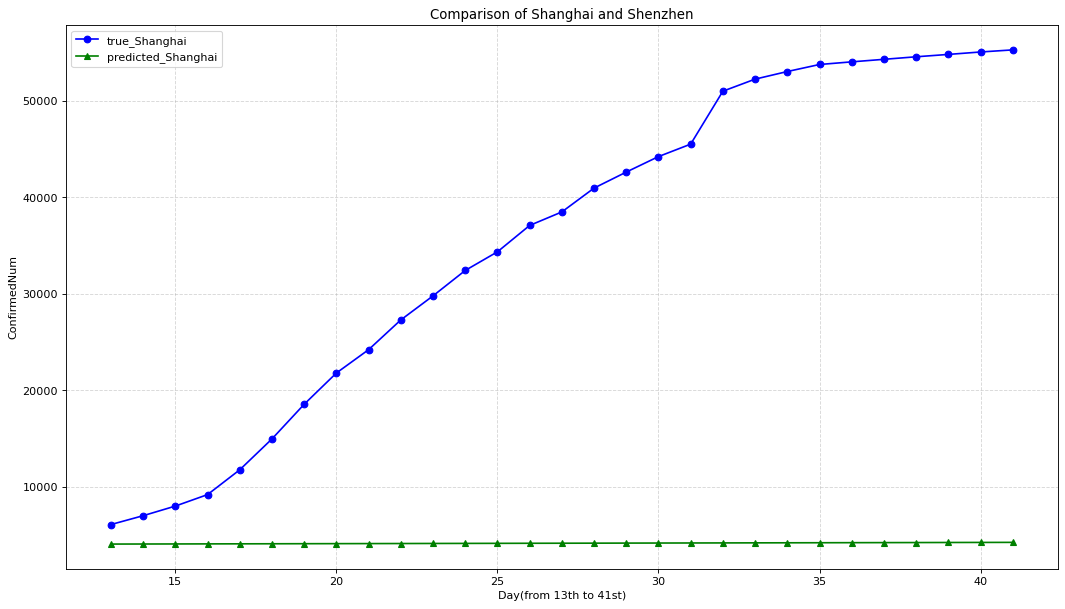

In [63]:

shanghai_numpy = shanghai.numpy()
shanghai_numpy = np.delete(shanghai_numpy, np.s_[-30:], axis=0)
predict_shanghai_through_shenzhen = list()
origin = scaler_dict['shanghai'].inverse_transform(shanghai_numpy[:,1].reshape(-1, 1))
origin = scaler_dict['shenzhen'].transform(origin)
shanghai_numpy[:,1] = origin.reshape(1,-1)[0]
for i in range(0, 29):
    shanghai_temp = torch.from_numpy(shanghai_numpy)
    not_inversed, inversed = predict_new(model_dict['shenzhen'],'shenzhen',shanghai_temp[i:i+TIMESTEP],shanghai_temp[TIMESTEP-1,1])
    not_inversed = not_inversed.numpy()
    predict_shanghai_through_shenzhen.append(math.ceil(inversed))
    t = np.append(scaler_x.transform(np.array([i + 13]).reshape(-1, 1).astype(int)), [[not_inversed]], axis=1)
    shanghai_numpy = np.append(shanghai_numpy, t, axis=0)
print(predict_shanghai_through_shenzhen)
np_predict_shanghai_through_shenzhen = np.array(predict_shanghai_through_shenzhen).reshape(-1, 1)
x = np.array([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]).reshape(-1, 1)
df = pd.read_csv("./input/shanghai_data.csv" ,header=0)
true_shanghai = list()
for i in range(0, 29):
    true_shanghai.append(df.iloc[28 - i, 1])
np_true_shanghai = np.array(true_shanghai).reshape(-1, 1)
plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('Comparison of Shanghai and Shenzhen')
plt.plot(x, np_true_shanghai, color='b', marker='o', label='true_Shanghai')
plt.plot(x, np_predict_shanghai_through_shenzhen, color='g', marker='^', label='predicted_Shanghai')
plt.legend()
plt.show()

[1619, 1632, 1644, 1654, 1663, 1670, 1677, 1681, 1686, 1689, 1692, 1694, 1696, 1698, 1698, 1698, 1698, 1698, 1698, 1698]
[37698, 41881, 46975, 48064, 47609, 47132, 47003, 48141, 49212, 49078, 47545, 45431, 44905, 43282, 43074, 42890, 42793, 42726, 42657, 42600]
[16591, 16773, 17039, 17754, 18551, 19205, 19965, 20547, 21185, 21805, 22433, 23299, 23774, 24073, 24091, 24100, 24104, 24102, 24092, 24079]


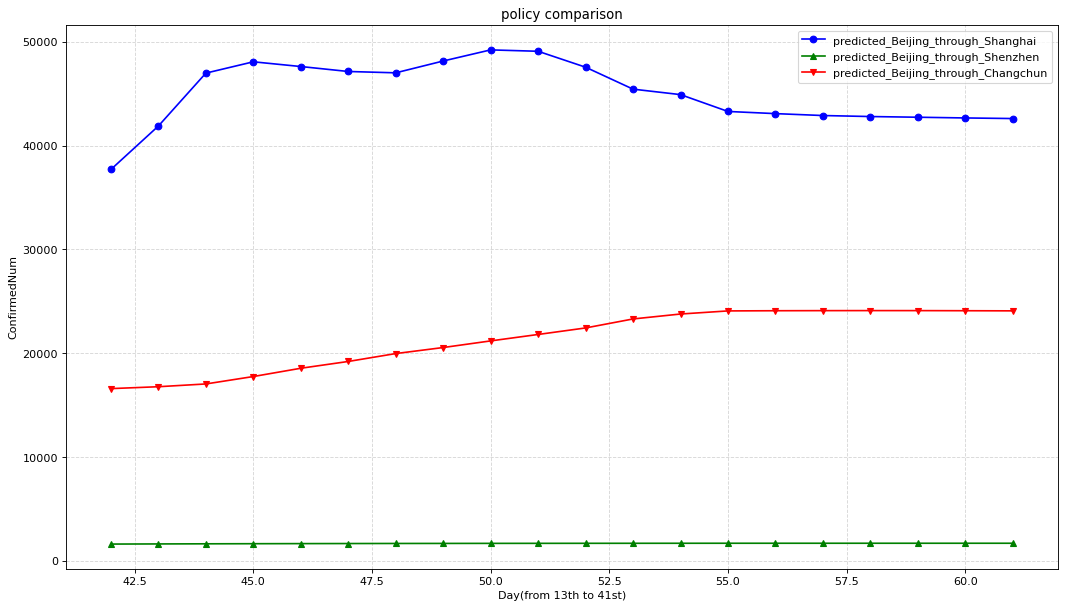

In [64]:
beijing_numpy = beijing.numpy().copy()
origin = scaler_dict['beijing'].inverse_transform(beijing_numpy[:,1].reshape(-1, 1))
origin = scaler_dict['shenzhen'].transform(origin)
beijing_numpy[:,1] = origin.reshape(1,-1)[0]
predict_beijing_through_shenzhen = list()
for i in range(29, 49):
    beijing_temp = torch.from_numpy(beijing_numpy)
    # print(beijing_temp)
    not_inversed, inversed = predict_new(model_dict['shenzhen'],'shenzhen',beijing_temp[i:i+TIMESTEP],beijing_temp[TIMESTEP-1,1])
    not_inversed = not_inversed.numpy()
    # print(not_inversed, inversed)
    predict_beijing_through_shenzhen.append(math.ceil(inversed))
    t = np.append(scaler_x.transform(np.array([i + 13]).reshape(-1, 1).astype(int)), [[not_inversed]], axis=1)
    beijing_numpy = np.append(beijing_numpy, t, axis=0)
print(predict_beijing_through_shenzhen)
# print(beijing_numpy)
beijing_numpy = beijing.numpy().copy()
origin = scaler_dict['beijing'].inverse_transform(beijing_numpy[:,1].reshape(-1, 1))
origin = scaler_dict['shanghai'].transform(origin)
beijing_numpy[:,1] = origin.reshape(1,-1)[0]
predict_beijing_through_shanghai = list()
for i in range(29, 49):
    beijing_temp = torch.from_numpy(beijing_numpy)
    # print(beijing_temp)
    not_inversed, inversed = predict_new(model_dict['shanghai'],'shanghai',beijing_temp[i:i+TIMESTEP],beijing_temp[TIMESTEP-1,1])
    not_inversed = not_inversed.numpy()
    # print(not_inversed, inversed)
    predict_beijing_through_shanghai.append(math.ceil(inversed))
    t = np.append(scaler_x.transform(np.array([i + 13]).reshape(-1, 1).astype(int)), [[not_inversed]], axis=1)
    beijing_numpy = np.append(beijing_numpy, t, axis=0)
print(predict_beijing_through_shanghai)
beijing_numpy = beijing.numpy().copy()
origin = scaler_dict['beijing'].inverse_transform(beijing_numpy[:,1].reshape(-1, 1))
origin = scaler_dict['changchun'].transform(origin)
beijing_numpy[:,1] = origin.reshape(1,-1)[0]
predict_beijing_through_changchun = list()
for i in range(29, 49):
    beijing_temp = torch.from_numpy(beijing_numpy)
    # print(beijing_temp)
    not_inversed, inversed = predict_new(model_dict['changchun'],'changchun',beijing_temp[i:i+TIMESTEP],beijing_temp[TIMESTEP-1,1])
    not_inversed = not_inversed.numpy()
    # print(not_inversed, inversed)
    predict_beijing_through_changchun.append(math.ceil(inversed))
    t = np.append(scaler_x.transform(np.array([i + 13]).reshape(-1, 1).astype(int)), [[not_inversed]], axis=1)
    beijing_numpy = np.append(beijing_numpy, t, axis=0)
print(predict_beijing_through_changchun)

np_predict_beijing_through_shenzhen = np.array(predict_beijing_through_shenzhen).reshape(-1, 1)
np_predict_beijing_through_shanghai = np.array(predict_beijing_through_shanghai).reshape(-1, 1)
np_predict_beijing_through_changchun = np.array(predict_beijing_through_changchun).reshape(-1, 1)
x = np.array([42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61]).reshape(-1, 1)

plt.figure(figsize=(16,9), dpi=80)
plt.grid(True, linestyle='--', alpha=0.5) #风格设置为虚线，alpha为透明度
plt.xlabel('Day(from 13th to 41st)')
plt.ylabel('ConfirmedNum')
plt.title('policy comparison')
plt.plot(x, np_predict_beijing_through_shanghai, color='b', marker='o', label='predicted_Beijing_through_Shanghai')
plt.plot(x, np_predict_beijing_through_shenzhen, color='g', marker='^', label='predicted_Beijing_through_Shenzhen')
plt.plot(x, np_predict_beijing_through_changchun, color='r', marker='v', label='predicted_Beijing_through_Changchun')

plt.legend()
plt.show()